In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from nbdev import *
%nbdev_default_export data_realsr

Cells will be exported to srthesis.data_realsr,
unless a different module is specified after an export flag: `%nbdev_export special.module`


In [ ]:
%nbdev_export_internal
from fastai.vision import *
from PIL import Image as PILImage
import multiprocessing

# Config



In [ ]:
%nbdev_export_internal
path_dataset = Path('datasets/RealSR')

In [ ]:
%nbdev_export
path_dataset_realsr = path_dataset

In [ ]:
%nbdev_export_internal
selected_patches = [ \
            (Path('datasets/RealSR/Canon/Valid/2/Canon_003_LR2.png'), (1200, 1050)), \
            (Path('datasets/RealSR/Canon/Valid/2/Canon_010_LR2.png'), (1320, 790)), \
            (Path('datasets/RealSR/Canon/Valid/2/Canon_015_LR2.png'), (750, 780)), \
            (Path('datasets/RealSR/Canon/Valid/2/Canon_006_LR2.png'), (680, 540)), \
            (Path('datasets/RealSR/Nikon/Valid/2/Nikon_006_LR2.png'), (660, 1160)), \
            (Path('datasets/RealSR/Nikon/Valid/2/Nikon_010_LR2.png'), (1020, 1050)), \
            (Path('datasets/RealSR/Nikon/Valid/2/Nikon_012_LR2.png'), (540, 700)), \
            (Path('datasets/RealSR/Nikon/Valid/2/Nikon_014_LR2.png'), (1200, 700)), \
           ]

In [ ]:
%nbdev_export
test_patches = [path_dataset/ "Test" / Path(fn).name for fn, _ in selected_patches]

# Dataset

In [ ]:
%nbdev_export_internal
def _open_image(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        x = PIL.Image.open(fn).convert(convert_mode)
    if after_open: x = after_open(x)
    xt = pil2tensor(x,np.float32)
    x.close()
    if div: xt.div_(255)
    return cls(xt)

open_image = _open_image

In [ ]:
%nbdev_export
class CachedImageList(ImageImageList):
    repeat:int = 1
    
    def __len__(self)->int: return len(self.items) * self.repeat or 1
    
    def load(self):
        self.image_data = []
        
        for i in range(len(self.items)):
            im = super().get(i)
            im.data.share_memory_()
            self.image_data.append(im)

        self.real_size = len(self.items)
        print("Image List loaded")
        print(self.items[0])
            
    def get(self, i):          
        if not hasattr(self, 'image_data'):
            self.load()
        return self.image_data[i % self.real_size]

    
class CachedImageImageList(CachedImageList):
    _label_cls = CachedImageList    

In [ ]:
%nbdev_export_internal
def _str_contains(string:str, parts:List[str]):
    res = [ele for ele in parts if ele in string]
    return bool(res)

def _str_replace(string:PathOrStr, replaced_parts:List[str], replace_with:str):
    parts = [p+'.' for p in replaced_parts]
    replace_with = replace_with + '.'
    res = str(string)
    for p in parts:
        res = res.replace(p, replace_with)
    return res

In [ ]:
%nbdev_export_internal

def _repeat_il(il:ImageList, times:int=2)->ImageList:
#     il_orig = il.new(il.items)
#     for i in range(times - 1):
#         il.add(il_orig)
    il.repeat = times
    return il

def _get_il(input_type:Tuple[str]='LR2', 
            det_valid = True,
            cached = True):
    
    input_train = [t+'.' for t in input_type[0].split('|')]
    input_valid = [t+'.' for t in input_type[1].split('|')]
    
    il_cls = CachedImageImageList if cached else ImageList
    
    il_canon = il_cls.from_folder(path_dataset / 'Canon') \
               .filter_by_func(lambda fname: '/2/' in str(fname)) \
               .filter_by_func(lambda fname:  _str_contains(str(fname), input_train))

    il_nikon = il_cls.from_folder(path_dataset / 'Nikon') \
                       .filter_by_func(lambda fname: '/2/' in str(fname)) \
                       .filter_by_func(lambda fname: _str_contains(str(fname), input_train))

    il_canon.add(il_nikon)
    il = il_canon
    
    if det_valid:
        #remove orig valid
        il = il.filter_by_func(lambda fname: 'Valid' not in str(fname)) 
        #add preselected patches
        il_valid = il_cls.from_folder(path_dataset / 'Valid') \
                        .filter_by_func(lambda fname: _str_contains(str(fname),input_valid))
        il.add(il_valid)
    
    il.items.sort()
    
    return il

In [ ]:
%nbdev_export
def _get_src(keep_pct: float = 1.0, 
             random_seed: int = 42,
             input_type:Tuple[str]=('LR2','LR2'),
             repeat_train:int = 1,
             repeat_valid:int = 1,
             max_train_len: int = sys.maxsize,
             train_include: List[str] = [],
             train_ignore: List[str] = [],
             det_valid=True):
    
    il = _get_il(input_type=input_type, det_valid=det_valid)
    
    if keep_pct < 1.0:
         il = il.use_partial_data(sample_pct=keep_pct, seed=random_seed)
    
    src = il.split_by_valid_func(lambda fname: "Valid" in str(fname))
    
    if max_train_len < len(src.train):
        if random_seed is not None: np.random.seed(random_seed)
        rand_idx = np.random.permutation(range_of(src.train))
        src.train = src.train[rand_idx[:max_train_len]]
        print(f"Train set limited to {max_train_len}.")
    
    #ignore
    src.train.filter_by_func(lambda fname: not _str_contains(str(fname), train_ignore))
    
    #include
    src.train.add(CachedImageImageList([Path(fn) for fn in train_include]))
    
    print(f'Train length: {len(src.train)}')
    
    if repeat_train > 1:
        src.train = _repeat_il(src.train, repeat_train)
        
    if repeat_valid > 1:
        src.valid = _repeat_il(src.valid, repeat_valid)
    
    src.path = src.path.parent
    
    return src

In [ ]:
_get_src(input_type =('NN15','LR2'))

Train length: 153
Image List loaded
datasets/RealSR/Canon/Train/2/Canon_001_NN15.png
Image List loaded
datasets/RealSR/Valid/Canon_003_LR2.png


ItemLists;

Train: CachedImageImageList (153 items)
Image (3, 1000, 1500),Image (3, 2300, 2600),Image (3, 1400, 1200),Image (3, 1000, 1400),Image (3, 1000, 1500)
Path: datasets/RealSR/Canon;

Valid: CachedImageImageList (158 items)
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: datasets/RealSR/Canon;

Test: None

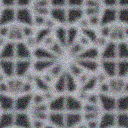

In [ ]:
def _add_noise(x, mean=0., std=0.01):
    return (x + torch.randn(x.size()) * std + mean).clamp(0.,1.)

add_noise_tfm = TfmPixel(_add_noise)

add_noise = add_noise_tfm(mean=0., std=0.06)
x = data.valid_ds.x[1].clone()
x.apply_tfms([add_noise])

In [ ]:
%nbdev_export_internal
def _get_tfms(y_size:int, dihedral_augs:bool=True, valid_len:int=None):
    crop_rand_patches = crop(size=(y_size,y_size),  row_pct=(0,1), col_pct=(0,1))# pct 
    crop_center_patches = crop(size=(y_size,y_size),  row_pct=0.5, col_pct=0.5)# pct 
    add_noise = add_noise_tfm(mean=0., std=1.)
    #TODO brightness and contrast
    #TODO noise
    train_tfms = [crop_rand_patches]
    if dihedral_augs:
        train_tfms += [dihedral_affine()]
    valid_tfms = []
    return [train_tfms, valid_tfms]
    

In [ ]:
%nbdev_export
get_il_realsr = _get_il
get_src_realsr = _get_src

In [ ]:
input_train = 'BIC|NN|NN153'
output_type = 'HR'

In [ ]:
#export
"""Obtain DataBunch for given target image size and batch size"""
def get_data_realsr(y_size,
             bs,
             keep_pct: float = 1.0,
             xtra_tfms=[],
             random_seed: int = 43,       
             input_type:[str, Tuple[str]] = 'LR2', 
             output_type:str = 'HR',
             repeat_train = 1,
             repeat_valid = 1,
             max_train_len: int = sys.maxsize,
             train_include: List[str] = [],
             train_ignore: List[str] = [],
             dihedral_augs = True,
             device=defaults.device,
             num_workers = None,
             stats: tuple = imagenet_stats) -> ImageDataBunch:
    input_type = (input_type, input_type) if type(input_type) is str else input_type
    input_train, input_valid = input_type
     
    src = _get_src(keep_pct, random_seed, input_type, repeat_train, repeat_valid, max_train_len, train_include, train_ignore)
    
    replace_fun = partial(_str_replace, replaced_parts=input_train.split('|') + [input_valid], replace_with=output_type)
    
    ll = src.label_from_func(replace_fun)
    
    iters_in_epoch = int(math.ceil(len(src.train) / float(bs)))

    if num_workers is None:
        num_workers = min(iters_in_epoch, multiprocessing.cpu_count() // 4) 
    
    print(f"Data: Iters in epoch: {iters_in_epoch}, loading threads: {num_workers}")
    
    print(f"Device: {device}")
    
    data = (ll.transform(
                       _get_tfms(y_size, dihedral_augs, len(src.valid)), 
                       size=None, 
                       tfm_y=True)
                   .databunch(bs=bs, num_workers=num_workers, device=device)
                   .normalize(imagenet_stats, do_y=True)
            )
    data.c = 3
    return data

In [ ]:
#export
def get_critic_data_realsr(y_size,
             bs,
             gen_type:[str, Tuple[str]] = 'LR2', 
             orig_type:str = 'HR'):
    il = _get_il(input_type=(f'{gen_type}|{orig_type}',f'{gen_type}|{orig_type}'), cached=False)
    il = il.filter_by_func(lambda fname: 'Valid' not in str(fname)) 
    src = il.split_by_rand_pct()
    ll = src.label_from_func(lambda fname: orig_type if orig_type in str(fname) else gen_type)
    
    crop_tfm = crop(size=(y_size,y_size),  row_pct=(0,1), col_pct=(0,1))
    
    data = (ll.transform(
                       [[crop_tfm],[crop_tfm]], 
                       size=None, 
                       tfm_y=False)
                   .databunch(bs=bs, num_workers=16)
                   .normalize(imagenet_stats)
            )
    
    return data

In [ ]:
data = get_critic_data_realsr(128, 16, gen_type='LR2', orig_type='HR')
data

In [ ]:
data = get_data_realsr(128, 16, input_type = ('LR2|NN|NN153', 'LR2'), output_type='HR', repeat_train = 1, max_train_len = 16)
data

Train set limited to 16.
Train length: 16
Data: Iters in epoch: 1, loading threads: 1
Device: cuda
Image List loaded
datasets/RealSR/Nikon/Train/2/Nikon_081_NN153.png
Image List loaded
datasets/RealSR/Nikon/Train/2/Nikon_081_HR.png
Image List loaded
datasets/RealSR/Valid/Canon_003_LR2.png
Image List loaded
datasets/RealSR/Valid/Canon_003_HR.png


ImageDataBunch;

Train: LabelList (16 items)
x: CachedImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CachedImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: datasets/RealSR/Canon;

Valid: LabelList (158 items)
x: CachedImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CachedImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: datasets/RealSR/Canon;

Test: None

Show some example inputs and targets in task

$ {LR}_{128px} -> {HR}_{256px} $

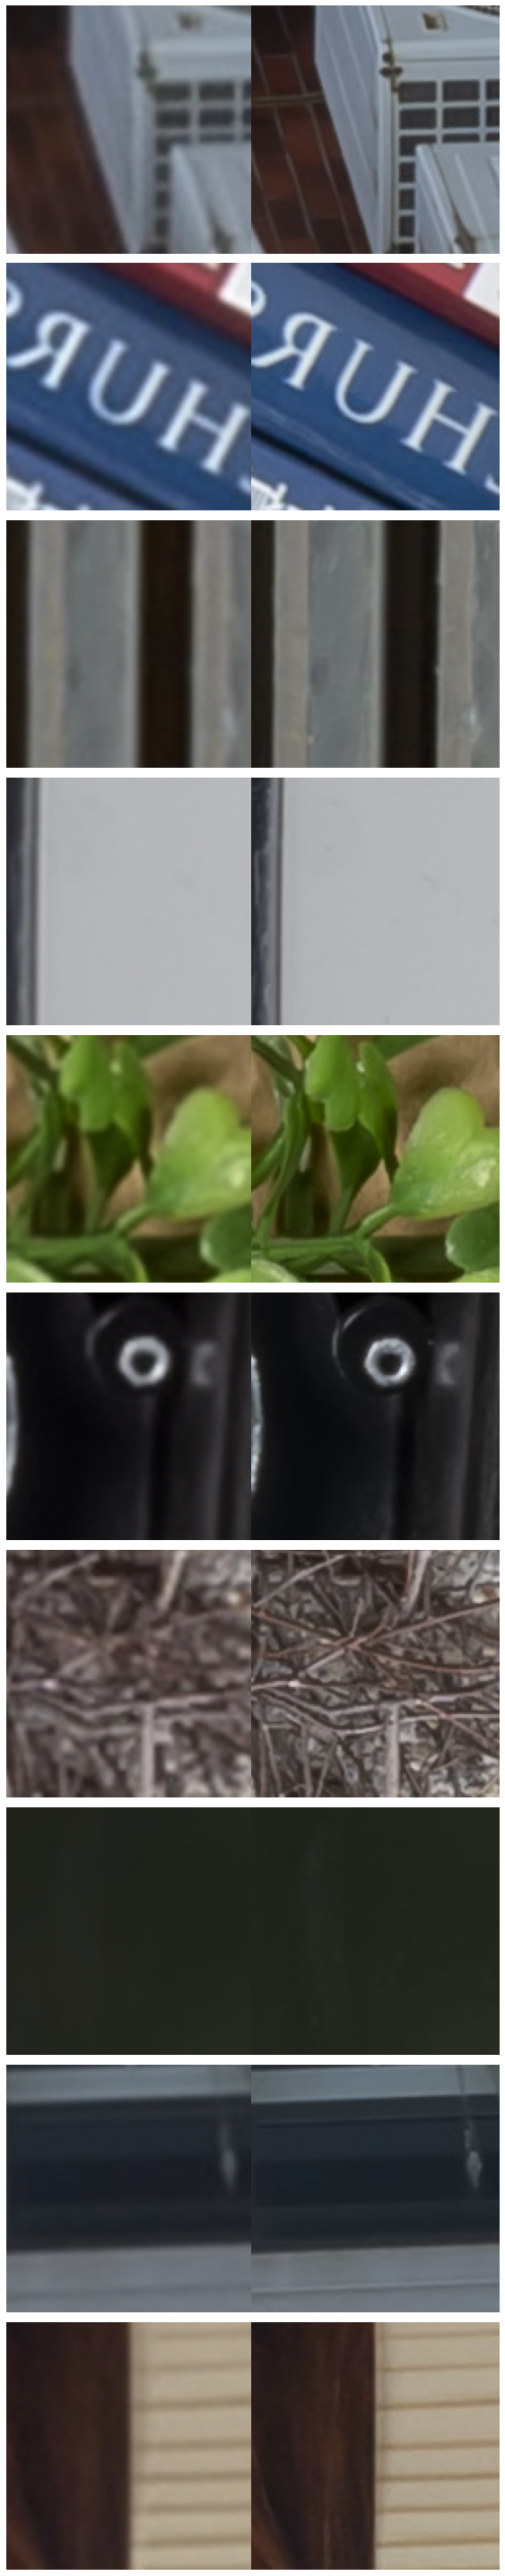

In [ ]:
data.show_batch(ds_type=DatasetType.Train, rows=10)

In [ ]:
x = data.valid_ds.x[1].clone()
x.apply_tfms([det_crop])

0.22546489298666783 0.45401587926583487


In [ ]:
%nbdev_hide
notebook2script()

Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted 0__template.ipynb.
Converted 10_data.ipynb.
Converted 11_div2k.ipynb.
Converted 12_realsr.ipynb.
Converted 13_dataset_generation.ipynb.
Converted 20_metrics.ipynb.
Converted 21_loss.ipynb.
Converted 22_callbacks.ipynb.
Converted 23_tensorboard.ipynb.
Converted 31_generator_learner.ipynb.
Converted 32_critic_learner.ipynb.
Converted 41_generator_pretraining.ipynb.
Converted 42_critic_pretraining.ipynb.
Converted 43_gan_training.ipynb.
Converted EXPERIMENTS JOURNAL.ipynb.
Converted augmentations.ipynb.
Converted graphs-tests.ipynb.
Converted sr reference.ipynb.
